In [2]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

In [3]:
llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

In [4]:
# Create Tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [5]:
# Create LLM that can call tools 
tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
sys_msg = SystemMessage(content="Either use tools to perform arithmetic on a set of inputs or just give me answer with your knowledge")
# Node to call LLM
def tool_calling_llm(state: MessagesState) -> MessagesState:
   response_message = llm_with_tools.invoke([sys_msg] + state["messages"])
   return {"messages": [response_message]}



In [7]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))   # Node to call tools


In [ ]:
# Define edges: these determine how the control flow moves
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")
#builder.add_edge("tool_calling_llm", END)
react_graph = builder.compile()

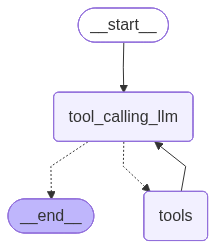

In [9]:
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [10]:
init_messages = [HumanMessage(content="Add 343433 and 4232323 then divide the result by 10")]
response_state = react_graph.invoke({"messages": init_messages})

In [11]:
for m in response_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 343433 and 4232323 then divide the result by 10
================================== Ai Message ==================================
Tool Calls:
  add (6698622d-32de-4b8d-b073-67d6507de828)
 Call ID: 6698622d-32de-4b8d-b073-67d6507de828
  Args:
    b: 4232323
    a: 343433
================================= Tool Message =================================
Name: add

4575756
================================== Ai Message ==================================
Tool Calls:
  divide (d8c6e001-5199-4609-a7f1-6a3890a7c0ba)
 Call ID: d8c6e001-5199-4609-a7f1-6a3890a7c0ba
  Args:
    a: 4575756
    b: 10
================================= Tool Message =================================
Name: divide

457575.6
================================== Ai Message ==================================

[{'type': 'text', 'text': 'The result is 457575.6.', 'extras': {'signature': 'CpoBAb4+9vtKt/id6QP9imu4NZlcJjdk5iQGuc0zqfsaklgCp7XcwZFcuU7

In [14]:
messages = [HumanMessage(content="What is the capital of Spain?")]
messages = react_graph.invoke({"messages": messages})


for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the capital of Spain?
================================== Ai Message ==================================

[{'type': 'text', 'text': 'The capital of Spain is Madrid.', 'extras': {'signature': 'Co8CAXLI2nwxsi+07dWw9zgxbK7AU/bnmcg2QEbzQtWq7AzMYuCrLlz2f2y1n6qwefyqsqF0hOeNP3IWFex04Yoz62B8y43gtEvnqfgfpSEEhQmHm4o1ZHdBtZdcLhDXdE0xJ8710W6q+U5EBOb1/pAPmsxwAUUqK5T4lGoSbrW+M6QwPyKT2DuhV+4ufUCvq1eVvkpKe9ebnMzd69A5uze4rGpa27GXMZgDRlQzQyt1CclDCdxeTooHvebyvsEhj1REgNWZIu5ZV+IJL/LfrSwDk4duQWvNskkpGciTz1jnwjrV/p7OC94IkGBYbUryl60fGAiimu/6wI/uQNSEP53SRcVFkVfWqsz6dpPGPfBAIg=='}}]
